In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [20]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\envym\tensorflow_datasets\tf_flowers\incomplete.EJTX7H_3.0.1\tf_flowers-train.tfrecord*...:…

Dataset tf_flowers downloaded and prepared to C:\Users\envym\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [21]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


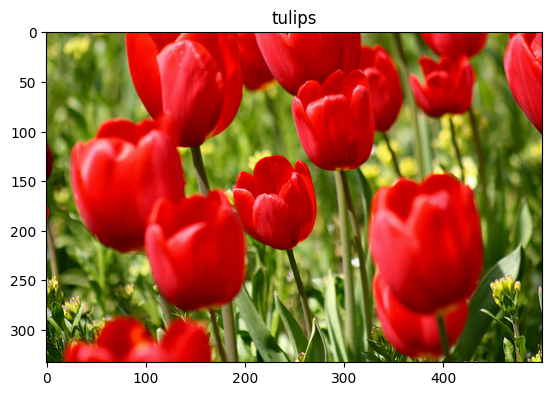

In [22]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [24]:
# 데이터 전처리 (정규화 및 배치 처리)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # VGG 모델의 입력 크기에 맞게 조정
    image = image / 255.0  # 픽셀 값을 0~1로 정규화
    return image, label

train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

class_names = metadata.features['label'].names
print(f"클래스 이름: {class_names}")

클래스 이름: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [25]:
# VGG16 모델 불러오기 (사전 학습된 가중치 사용)
base_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,  # Fully Connected Layer 제외
    weights='imagenet'
)

# 사전 학습된 레이어 고정
base_model.trainable = False

# 커스텀 분류기 추가
model = models.Sequential([
    base_model,  # VGG16의 Convolution Base
    layers.Flatten(),  # FC 레이어로 연결
    layers.Dense(128, activation='relu'),  # 추가 Dense Layer
    layers.Dense(len(class_names), activation='softmax')  # 클래스 개수에 맞춘 출력
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,725 (68.39 MB)

 Trainable params: 3,212,037 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.4890 - loss: 1.9430 - val_accuracy: 0.7684 - val_loss: 0.6141
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.8518 - loss: 0.4395 - val_accuracy: 0.8065 - val_loss: 0.5356
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.9249 - loss: 0.2638 - val_accuracy: 0.7302 - val_loss: 0.8144
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.9239 - loss: 0.2248 - val_accuracy: 0.7575 - val_loss: 0.7992
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9009 - loss: 0.2418 - val_accuracy: 0.8038 - val_loss: 0.7350
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9077 - loss: 0.2481 - val_accuracy: 0.8065 - val_loss: 0.6399
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9845 - loss: 0.0551 - val_accuracy: 0.8011 - val_loss: 0.6265
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9949 - loss: 0.0310 - val_accuracy: 0.7929 - v

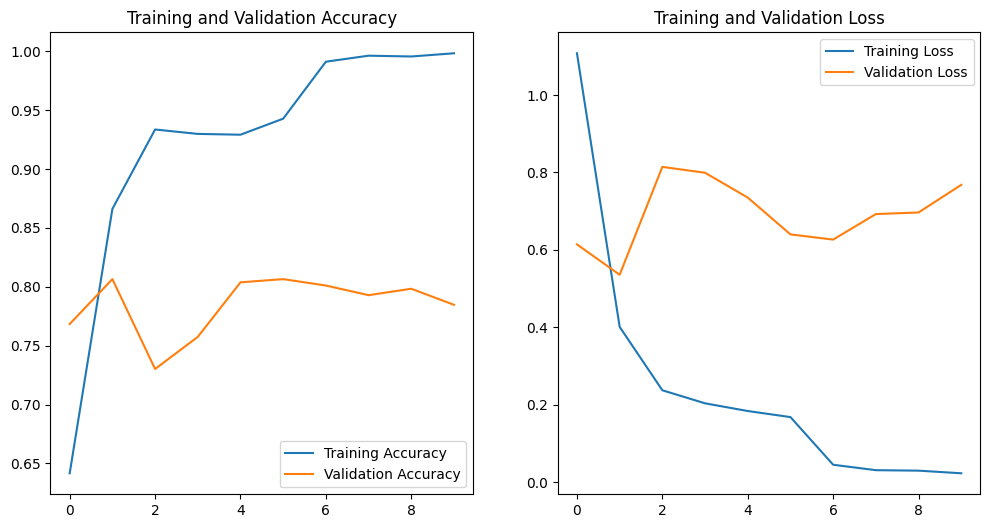

In [27]:
# 정확도와 손실 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [28]:
loss, accuracy = model.evaluate(test_ds)
print(f"테스트 데이터 정확도: {accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8012 - loss: 0.6298
테스트 데이터 정확도: 81.47%


In [30]:
# 일부 레이어만 학습 가능하게 설정
base_model.trainable = True
for layer in base_model.layers[:15]:  # 처음 15개 레이어는 고정
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
EPOCHS = 5

# Fine-tuning 학습
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.9597 - loss: 0.1207 - val_accuracy: 0.8065 - val_loss: 0.7185
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.9734 - loss: 0.0835 - val_accuracy: 0.8311 - val_loss: 0.5814
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.9827 - loss: 0.0479 - val_accuracy: 0.8638 - val_loss: 0.5189
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.9981 - loss: 0.0126 - val_accuracy: 0.8447 - val_loss: 0.6654
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.9954 - loss: 0.0151 - val_accuracy: 0.8420 - val_loss: 0.8438


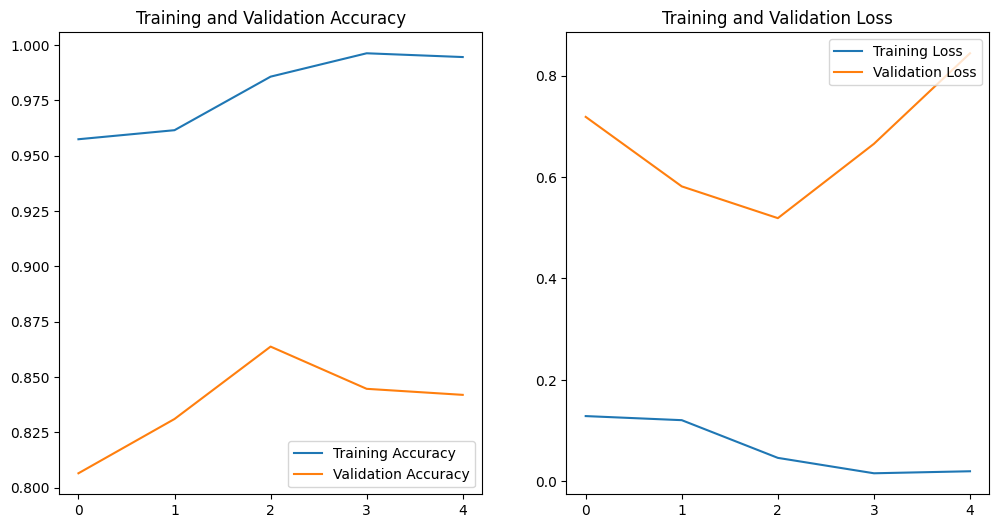

In [36]:
# 정확도와 손실 시각화
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xticks(ticks=epochs_range)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xticks(ticks=epochs_range)

plt.show()



In [37]:
loss, accuracy = model.evaluate(test_ds)
print(f"테스트 데이터 정확도: {accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8395 - loss: 0.6794
테스트 데이터 정확도: 86.38%


In [38]:
import numpy as np
import requests
from PIL import Image


# URL에서 이미지를 가져와 처리하는 함수
def preprocess_image_from_url(url, img_size=(224, 224)):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    img = Image.open(response.raw).convert('RGB')  # 이미지 열기 및 RGB 변환
    img = img.resize(img_size)  # 이미지 크기 조정
    img_array = np.array(img) / 255.0  # 0~1로 정규화
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    return img, img_array


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Predicted Class: dandelion
Confidence: 1.00


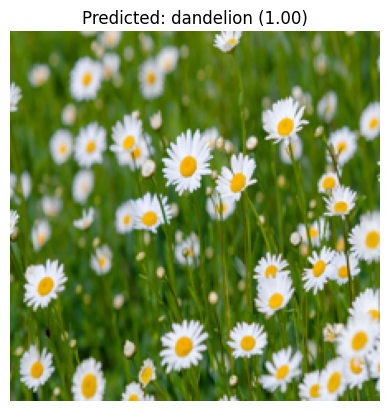

In [39]:
url = "https://www.thespruce.com/thmb/Gml8R1jKSxCOGLlJqXrlhGKICa4=/4288x0/filters:no_upscale():max_bytes(150000):strip_icc()/oxeye-daisy-growing-guide-5190951-hero-baed472653934a6da8c8f86237dcf7bc.jpg"

# 이미지 전처리
img, img_array = preprocess_image_from_url(url)

# 모델 출력 (사전 학습된 VGG16을 사용한 예)
prediction = model.predict(img_array)

# 클래스 이름 가져오기
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # 꽃 클래스 이름

# 결과 출력
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# 입력 이미지와 분류 결과 시각화
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Class: sunflowers
Confidence: 0.94


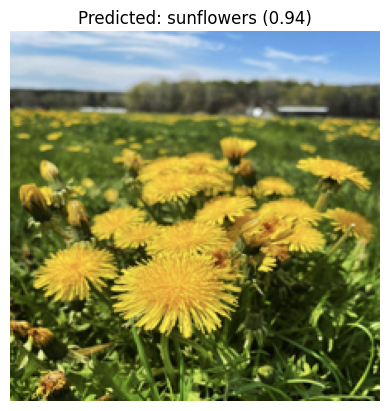

In [40]:
url = "https://images.squarespace-cdn.com/content/v1/64c7ea285040523efd4ceb09/1692139181326-415UJMK753HNN5Z4269Y/dandelion%2Bflowers%2Bjust%2Broots.jpg"

# 이미지 전처리
img, img_array = preprocess_image_from_url(url)

# 모델 출력 (사전 학습된 VGG16을 사용한 예)
prediction = model.predict(img_array)

# 클래스 이름 가져오기
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # 꽃 클래스 이름

# 결과 출력
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# 입력 이미지와 분류 결과 시각화
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Predicted Class: tulips
Confidence: 1.00


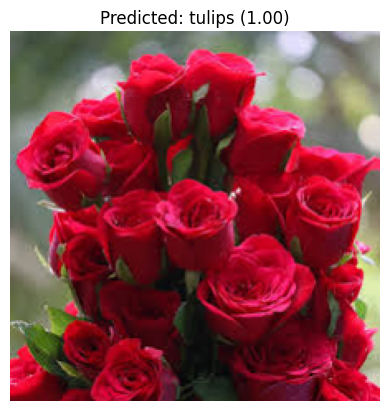

In [42]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXVZZliLgkKIp9zRtP5U2iVR6X3-9BPknXSg&s"

# 이미지 전처리
img, img_array = preprocess_image_from_url(url)

# 모델 출력 (사전 학습된 VGG16을 사용한 예)
prediction = model.predict(img_array)

# 클래스 이름 가져오기
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # 꽃 클래스 이름

# 결과 출력
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# 입력 이미지와 분류 결과 시각화
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Predicted Class: sunflowers
Confidence: 1.00


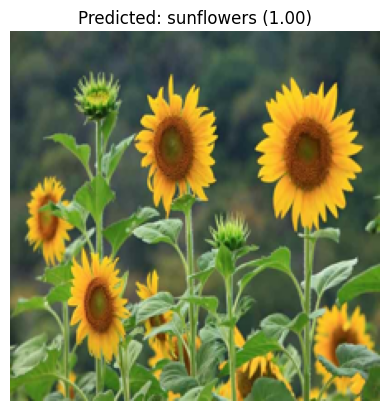

In [43]:
url = "https://www.gardenia.net/wp-content/uploads/2024/01/shutterstock_2084235901-800x533.jpg"

# 이미지 전처리
img, img_array = preprocess_image_from_url(url)

# 모델 출력 (사전 학습된 VGG16을 사용한 예)
prediction = model.predict(img_array)

# 클래스 이름 가져오기
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # 꽃 클래스 이름

# 결과 출력
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# 입력 이미지와 분류 결과 시각화
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted Class: roses
Confidence: 1.00


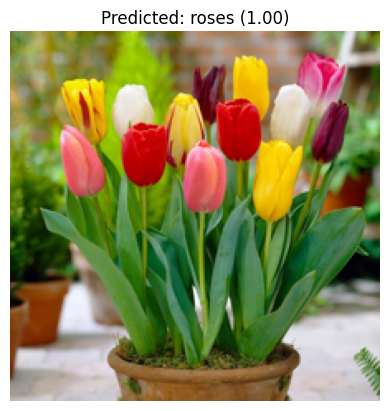

In [45]:
url = "https://m.media-amazon.com/images/I/71sQOlkixLL.jpg"

# 이미지 전처리
img, img_array = preprocess_image_from_url(url)

# 모델 출력 (사전 학습된 VGG16을 사용한 예)
prediction = model.predict(img_array)

# 클래스 이름 가져오기
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # 꽃 클래스 이름

# 결과 출력
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# 입력 이미지와 분류 결과 시각화
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()

성능이 너무 안 좋다 ㅋㅋㅋㅋㅋㅋ 5개 중 1개만 맞추다니....